In [1]:
import torch
import trimesh
import numpy as np
import skvideo.io
import imageio
from scipy.interpolate import CubicSpline
from munch import *
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F
from torch.utils import data
from torchvision import utils
from torchvision import transforms
from options import BaseOptions
from model import Generator
from utils import (
    generate_camera_params, align_volume, extract_mesh_with_marching_cubes,
    xyz2mesh, create_cameras, create_mesh_renderer, add_textures,
    )
from pytorch3d.structures import Meshes
from dataset import color_segmap
from pdb import set_trace as st
import os

In [2]:
device = "cuda"
opt = BaseOptions().parse()
opt.model.is_test = True
opt.model.style_dim = 256
opt.model.freeze_renderer = False
opt.rendering.depth = 3
opt.rendering.width = 128
opt.rendering.no_features_output = False
opt.inference.size = opt.model.size
opt.inference.camera = opt.camera
opt.inference.renderer_output_size = opt.model.renderer_spatial_output_dim
opt.inference.style_dim = opt.model.style_dim
opt.inference.project_noise = opt.model.project_noise
opt.rendering.perturb = 0
opt.rendering.force_background = True
opt.rendering.static_viewdirs = True
opt.rendering.return_sdf = False
opt.rendering.return_xyz = True
opt.rendering.N_samples = 24
opt.rendering.no_features_output = False
opt.experiment.ckpt = 25000

usage: ipykernel_launcher.py [-h] [--dataset_path DATASET_PATH] [--config CONFIG] [--expname EXPNAME] [--ckpt CKPT]
                             [--continue_training] [--checkpoints_dir CHECKPOINTS_DIR] [--trained_ckpt TRAINED_CKPT]
                             [--pretrain_render_path PRETRAIN_RENDER_PATH] [--iter ITER] [--batch BATCH]
                             [--chunk CHUNK] [--val_n_sample VAL_N_SAMPLE] [--d_reg_every D_REG_EVERY]
                             [--g_reg_every G_REG_EVERY] [--local_rank LOCAL_RANK] [--mixing MIXING] [--lr LR]
                             [--Semantic_D_lambda SEMANTIC_D_LAMBDA] [--r1_img R1_IMG] [--r1_seg R1_SEG]
                             [--view_lambda VIEW_LAMBDA] [--eikonal_lambda EIKONAL_LAMBDA]
                             [--min_surf_lambda MIN_SURF_LAMBDA] [--min_surf_beta MIN_SURF_BETA]
                             [--path_regularize PATH_REGULARIZE] [--path_batch_shrink PATH_BATCH_SHRINK] [--wandb]
                             [--no_spher

In [3]:
opt.training.checkpoints_dir = 'checkpoints'

In [4]:
opt.training.trained_ckpt = 'checkpoints/models_0066000.pt'

In [5]:
os.makedirs(opt.inference.results_dir, exist_ok=True)
checkpoint_path = opt.training.trained_ckpt
checkpoint = torch.load(checkpoint_path)

In [6]:
g_ema = Generator(opt.model, opt.rendering, full_pipeline=False).to(device)

C:\Users\phdsa\miniconda3\envs\deep\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
pretrained_weights_dict = checkpoint["g_ema"]
model_dict = g_ema.state_dict()
for k, v in pretrained_weights_dict.items():
    if v.size() == model_dict[k].size():
        model_dict[k] = v
g_ema.load_state_dict(model_dict)

<All keys matched successfully>

In [8]:
with torch.no_grad():
    mean_latent = g_ema.mean_latent(opt.inference.truncation_mean, device)

In [10]:
semantics = 2

In [9]:
g_ema.eval()

Generator(
  (style): Sequential(
    (0): MappingLinear(256, 256)
    (1): MappingLinear(256, 256)
    (2): MappingLinear(256, 256)
  )
  (renderer): VolumeFeatureRenderer(
    (network): ModuleList(
      (0-11): 12 x SirenGenerator(
        (shape_linears): ModuleList(
          (0-2): 3 x FiLMSiren(
            (gamma): LinearLayer()
            (beta): LinearLayer()
          )
        )
        (texture_linears): ModuleList(
          (0-1): 2 x FiLMSiren(
            (gamma): LinearLayer()
            (beta): LinearLayer()
          )
        )
        (mask_linears): LinearLayer()
        (feature_linear): LinearLayer()
        (rgb_linear): LinearLayer()
        (sdf_linear): LinearLayer()
      )
    )
    (init_network): SirenGenerator(
      (shape_linears): ModuleList(
        (0-2): 3 x FiLMSiren(
          (gamma): LinearLayer()
          (beta): LinearLayer()
        )
      )
      (texture_linears): ModuleList(
        (0-1): 2 x FiLMSiren(
          (gamma): LinearLa

In [10]:
opt = opt.inference

In [11]:
num_frames = 1
trajectory = np.zeros((num_frames,3), dtype=np.float32)

t1 = np.linspace(-1.5, 1.5, 10)[3]
t2 = 0.8 * np.ones(num_frames)

fov = opt.camera.fov
elev = opt.camera.elev * t2
azim = opt.camera.azim * t1

trajectory[:num_frames,0] = azim
trajectory[:num_frames,1] = elev
trajectory[:num_frames,2] = fov

trajectory = torch.from_numpy(trajectory).to(device)

sample_cam_extrinsics, sample_focals, sample_near, sample_far, _ = \
generate_camera_params(opt.renderer_output_size, device, locations=trajectory[:,:2],
                       fov_ang=trajectory[:,2:], dist_radius=opt.camera.dist_radius)

cameras = create_cameras(azim=np.rad2deg(trajectory[0,0].cpu().numpy()),
                         elev=np.rad2deg(trajectory[0,1].cpu().numpy()),
                         dist=1, device=device)

In [13]:
sample_cam_extrinsics

tensor([[[ 0.9988, -0.0060,  0.0496,  0.0496],
         [ 0.0000,  0.9928,  0.1197,  0.1197],
         [-0.0500, -0.1196,  0.9916,  0.9916]]], device='cuda:0')

In [12]:
styles = g_ema.style(torch.randn(1, opt.style_dim, device=device))

In [13]:
styles.shape

torch.Size([1, 256])

In [16]:
torch.min(styles)

tensor(-0.8867, device='cuda:0', grad_fn=<MinBackward1>)

In [24]:
with torch.no_grad():
    direction = styles/torch.norm(styles)

In [25]:
style_mani = styles

In [26]:
torch.sum(style_mani)

tensor(142.7455, device='cuda:0', grad_fn=<SumBackward0>)

In [134]:
lambda_val = 12.5
styles_change = style_mani + lambda_val*direction
style_2 = opt.truncation_ratio * styles_change + (1-opt.truncation_ratio) * mean_latent[0]

In [14]:
styles = opt.truncation_ratio * styles + (1-opt.truncation_ratio) * mean_latent[0]
styles_global = styles

In [15]:
styles.shape

torch.Size([1, 256])

In [16]:
styles_new = styles.unsqueeze(1).repeat(1, g_ema.n_latent, 1)

In [17]:
styles_new.size()

torch.Size([1, 24, 256])

In [239]:
# style_2_n = g_ema.style(torch.randn(1, opt.style_dim, device=device))


In [279]:
# style_2 = 0.001 * style_2_n + (1-0.0001) * mean_latent[0]

In [272]:
# style_2 = 2*style_2

In [135]:
styles_new_new = styles.unsqueeze(1).repeat(1, g_ema.n_latent, 1)
styles_new_new[:,2*8:(2*8+2),:] = style_2

In [18]:
out = g_ema([styles_new],
            sample_cam_extrinsics,
            sample_focals,
            sample_near,
            sample_far,
            truncation=opt.truncation_ratio,
            truncation_latent=mean_latent,
            input_is_latent=True,
            randomize_noise=False,
            project_noise=opt.project_noise,
            mesh_path=frontal_marching_cubes_mesh_filename if opt.project_noise else None,
            styles_global=[styles_global],
            semantics=[8]
                            )

feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
raw shape is  torch.Size([12, 1, 64, 64, 24, 133])


In [136]:
out = g_ema([styles_new_new],
            sample_cam_extrinsics,
            sample_focals,
            sample_near,
            sample_far,
            truncation=opt.truncation_ratio,
            truncation_latent=mean_latent,
            input_is_latent=True,
            randomize_noise=False,
            project_noise=opt.project_noise,
            mesh_path=frontal_marching_cubes_mesh_filename if opt.project_noise else None,
            styles_global=[styles_global],
            semantics=[8]
                            )

feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
feature shape is torch.Size([1, 64, 64, 24, 128])
raw shape is  torch.Size([12, 1, 64, 64, 24, 133])


In [137]:
_, img, seg, f, img_sem = out

In [138]:
img

tensor([[[[-0.0608, -0.3571, -0.6412,  ..., -0.8280, -0.8239, -0.7928],
          [-0.2086, -0.6109, -0.6668,  ..., -0.8258, -0.8107, -0.7668],
          [-0.4420, -0.7379, -0.6193,  ..., -0.8214, -0.8036, -0.7575],
          ...,
          [-0.6077, -0.1399,  0.0805,  ..., -0.1208, -0.1518, -0.1812],
          [-0.1106,  0.3166,  0.2545,  ..., -0.0727, -0.0953, -0.1215],
          [ 0.1784,  0.5204,  0.1652,  ..., -0.0643, -0.0768, -0.1114]],

         [[-0.0550, -0.4049, -0.7118,  ..., -0.7775, -0.7742, -0.7457],
          [-0.1842, -0.6676, -0.7262,  ..., -0.7720, -0.7531, -0.7081],
          [-0.4444, -0.7815, -0.6667,  ..., -0.7699, -0.7442, -0.6898],
          ...,
          [-0.4294, -0.0971, -0.1877,  ..., -0.2737, -0.2886, -0.2882],
          [-0.0186,  0.2396, -0.0964,  ..., -0.2442, -0.2476, -0.2420],
          [ 0.1355,  0.3400, -0.2210,  ..., -0.2385, -0.2282, -0.2252]],

         [[-0.1426, -0.5315, -0.8037,  ..., -0.8333, -0.8349, -0.8203],
          [-0.2587, -0.7539, -

In [40]:
img[0:].shape

torch.Size([1, 3, 64, 64])

In [20]:
img_sem = img_sem.permute(0,3,1,2).contiguous()

In [21]:
img_sem.shape

torch.Size([1, 3, 64, 64])

In [30]:
img = img*seg[:,7]

In [139]:
del out
torch.cuda.empty_cache()

# img = img.clamp(-1,1) * 127.5 + 127.5
# img = img.detach().cpu()
img = img.clamp(-1,1) * 0.5 + 0.5
img = img.clamp(0, 1)
img = img.detach().cpu()
seg = color_segmap(seg)
seg = seg.detach().cpu()
seg = seg/255.

In [73]:
utils.save_image(img[0], 'check.png', normalize=True)

In [69]:
utils.save_image(seg[0], 'check_seg.png', normalize=True)

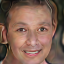

In [23]:
transforms.functional.to_pil_image(img[0])

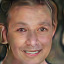

In [47]:
transforms.functional.to_pil_image(img[0])

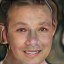

In [54]:
transforms.functional.to_pil_image(img[0])

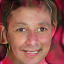

In [87]:
transforms.functional.to_pil_image(img[0])

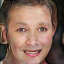

In [93]:
transforms.functional.to_pil_image(img[0])

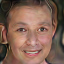

In [99]:
transforms.functional.to_pil_image(img[0])

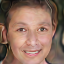

In [118]:
transforms.functional.to_pil_image(img[0])

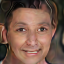

In [133]:
transforms.functional.to_pil_image(img[0])

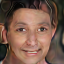

In [140]:
transforms.functional.to_pil_image(img[0])

In [24]:
img_sem = img_sem.clamp(-1,1) * 0.5 + 0.5
# img = img_seg.clamp(0, 1)
img_sem = img_sem.detach().cpu()

In [61]:
img_sem[img_sem > 0.54] = 1

In [25]:
torch.max(img_sem)

tensor(0.6567)

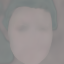

In [26]:
transforms.functional.to_pil_image(img_sem[0])

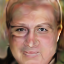

In [197]:
#9 is the mouth
transforms.functional.to_pil_image(img[0])

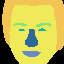

In [136]:
transforms.functional.to_pil_image(seg[0])